In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

returns_df = pd.read_csv('return_train_2017_2021.csv')
reddit_df = pd.read_csv('sentiment_train_2017_2021.csv')


# Inspect basic information
print("Reddit data shape:", reddit_df.shape)
print("Returns data shape:", returns_df.shape)
print("Reddit columns:", reddit_df.columns.tolist())
print("Returns columns:", returns_df.columns.tolist())


Reddit data shape: (11929999, 21)
Returns data shape: (2459589, 5)
Reddit columns: ['StoryID', 'Post_Time', 'Received_Time', 'Ticker', 'Country', 'ISIN', 'Relevance', 'Sentiment', 'Confidence', 'Prob_POS', 'Prob_NTR', 'Prob_NEG', 'Reddit_Topic', 'TopicWeight', 'Alex_Topic', 'Source', 'SourceWeight', 'LinkID', 'Author', 'Novelty', 'Comment_Count']
Returns columns: ['Date', 'Ticker', 'D0', 'D1', 'Return']


In [20]:
# Convert 'Received_Time' to datetime and localize to UTC then convert to ET
reddit_df['Received_Time'] = pd.to_datetime(reddit_df['Received_Time'])
reddit_df['Received_Time'] = reddit_df['Received_Time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')

# Create an 'Effective_Date' column:
# For posts at or after 4 PM ET, shift the date to the next day.
reddit_df['Effective_Date'] = reddit_df['Received_Time'].dt.date
after_4pm = reddit_df['Received_Time'].dt.hour >= 16
reddit_df.loc[after_4pm, 'Effective_Date'] = reddit_df.loc[after_4pm, 'Received_Time'].dt.date + pd.Timedelta(days=1)
reddit_df['Effective_Date'] = pd.to_datetime(reddit_df['Effective_Date'])



In [21]:
daily_sentiment = reddit_df.groupby(['Ticker', 'Effective_Date'])['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'Effective_Date': 'Date', 'Sentiment': 'Daily_Sentiment'}, inplace=True)

In [22]:
# Convert 'Date' to datetime
returns_df['Date'] = pd.to_datetime(returns_df['Date'])

# Convert 'Return' from percentage string to numeric if needed
if returns_df['Return'].dtype == object:
    returns_df['Return'] = returns_df['Return'].str.rstrip('%').astype('float') / 100

# Remove or handle missing values
returns_df.dropna(inplace=True)


In [23]:
# Shift the returns date by one day for proper alignment
returns_df['Signal_Date'] = returns_df['Date'] - pd.Timedelta(days=1)

# Merge the daily sentiment with the returns data on 'Ticker' and the adjusted date
merged_df = pd.merge(daily_sentiment, returns_df, left_on=['Ticker', 'Date'], right_on=['Ticker', 'Signal_Date'], how='inner')
merged_df.drop(columns=['Signal_Date'], inplace=True)
merged_df.rename(columns={'Return': 'Next_Day_Return'}, inplace=True)

print("Merged data shape:", merged_df.shape)
merged_df.head()


Merged data shape: (378895, 7)


,Ticker,Date_x,Daily_Sentiment,Date_y,D0,D1,Next_Day_Return
0,A,2017-01-03,1.0,2017-01-04,47.10,46.54,-0.0119
1,A,2017-02-06,1.0,2017-02-07,49.64,49.93,0.0058
2,A,2017-06-15,-1.0,2017-06-16,59.38,60.42,0.0175
3,A,2017-06-28,0.0,2017-06-29,58.80,59.31,0.0087
4,A,2017-07-18,0.0,2017-07-19,61.38,60.98,-0.0065


In [24]:
# Summary statistics for numerical columns
print(merged_df.describe())


                              Date_x  Daily_Sentiment  \
count                         378895    378895.000000   
mean   2020-02-17 22:14:26.652766208         0.278427   
min              2017-01-02 00:00:00        -1.000000   
25%              2019-02-20 00:00:00         0.000000   
50%              2020-06-17 00:00:00         0.264151   
75%              2021-04-27 00:00:00         1.000000   
max              2021-12-30 00:00:00         1.000000   
std                              NaN         0.586129   

                              Date_y             D0             D1  \
count                         378895  378895.000000  378895.000000   
mean   2020-02-18 22:14:26.652766208     117.146471     117.175827   
min              2017-01-03 00:00:00       0.010000       0.010000   
25%              2019-02-21 00:00:00      23.350000      23.350000   
50%              2020-06-18 00:00:00      54.180000      54.220000   
75%              2021-04-28 00:00:00     120.802370     120.900000

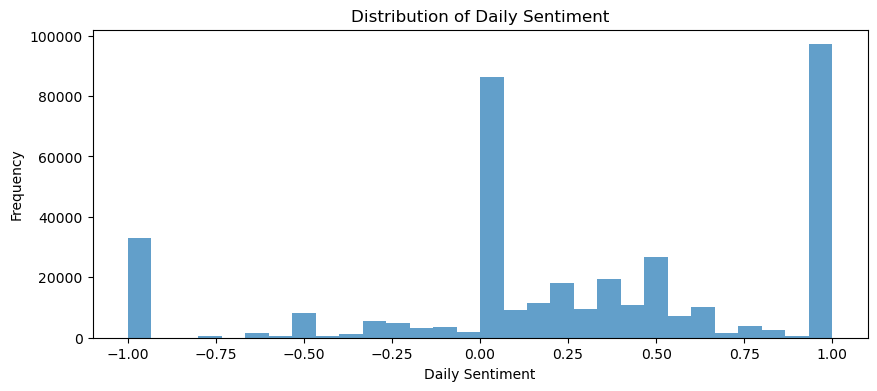

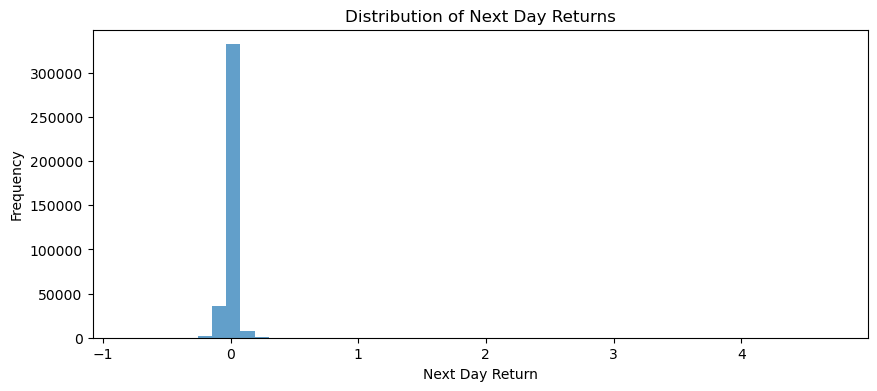

In [52]:

plt.figure(figsize=(10, 4))
plt.hist(merged_df['Daily_Sentiment'], bins=30, alpha=0.7)
plt.title('Distribution of Daily Sentiment')
plt.xlabel('Daily Sentiment')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(merged_df['Next_Day_Return'], bins=50, alpha=0.7)
plt.title('Distribution of Next Day Returns')
plt.xlabel('Next Day Return')
plt.ylabel('Frequency')
plt.show()


In [29]:
print(merged_df.columns.tolist())
merged_df.rename(columns={'Date_x': 'Date'}, inplace=True)



['Ticker', 'Date_x', 'Daily_Sentiment', 'Date_y', 'D0', 'D1', 'Next_Day_Return']


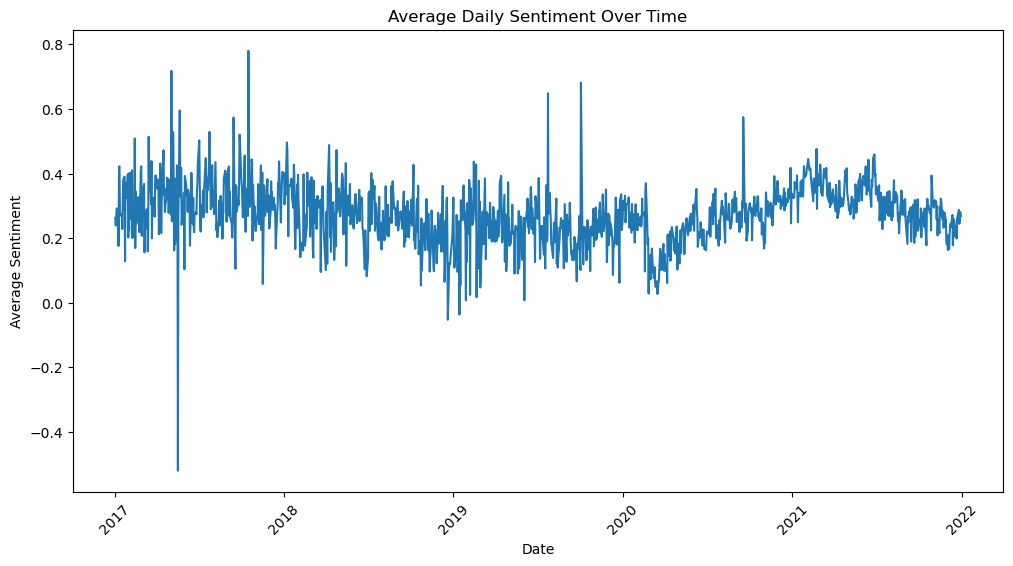

In [30]:
avg_sentiment_daily = merged_df.groupby('Date')['Daily_Sentiment'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.plot(avg_sentiment_daily['Date'], avg_sentiment_daily['Daily_Sentiment'])
plt.title('Average Daily Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.show()

In [31]:
correlation = merged_df[['Daily_Sentiment', 'Next_Day_Return']].corr()
print("Correlation between sentiment and returns:")
print(correlation)

Correlation between sentiment and returns:
                 Daily_Sentiment  Next_Day_Return
Daily_Sentiment         1.000000         0.002861
Next_Day_Return         0.002861         1.000000


In [32]:
ticker_counts = reddit_df.groupby('Ticker').size().reset_index(name='Post_Count')
print(ticker_counts.sort_values('Post_Count', ascending=False).head(10))

      Ticker  Post_Count
6740     GME     1389733
15649   TSLA      834091
671      AMC      490629
37      AAPL      381991
7480    HOOD      374329
12173   PLTR      304473
780     AMZN      263100
10376   MSFT      202108
684      AMD      197632
6843   GOOGL      173359


In [33]:
merged_df['Signal'] = merged_df['Daily_Sentiment']

In [36]:
def assign_quintiles(group):
    group = group.copy()
    # First, perform qcut to determine the actual number of bins.
    qcut_obj = pd.qcut(group['Signal'], 5, duplicates='drop')
    n_bins = len(qcut_obj.cat.categories)
    
    # Create custom labels for the bins.
    # For example, if you want the highest sentiment to be Q1 and lowest to be Q{n_bins},
    # generate labels accordingly:
    labels = ['Q' + str(i+1) for i in range(n_bins)]
    labels = labels[::-1]  # Reverse so highest sentiment gets Q1
    
    # Apply qcut again with the dynamically generated labels.
    group['Quintile'] = pd.qcut(group['Signal'], 5, labels=labels, duplicates='drop')
    return group

merged_df = merged_df.groupby('Date').apply(assign_quintiles).reset_index(drop=True)


/var/folders/qj/trm65tt92qn42r8m1wwrh78w0000gn/T/ipykernel_36315/2283185976.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('Date').apply(assign_quintiles).reset_index(drop=True)


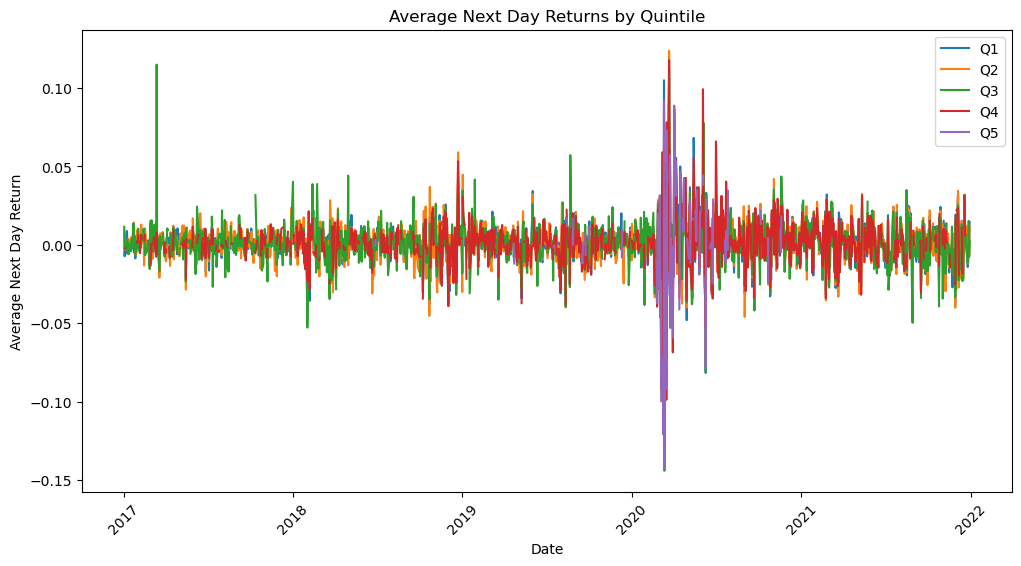

In [37]:
quintile_returns = merged_df.groupby(['Date', 'Quintile'])['Next_Day_Return'].mean().reset_index()
quintile_returns_pivot = quintile_returns.pivot(index='Date', columns='Quintile', values='Next_Day_Return')

plt.figure(figsize=(12,6))
for q in ['Q1','Q2','Q3','Q4','Q5']:
    plt.plot(quintile_returns_pivot.index, quintile_returns_pivot[q], label=q)
plt.title('Average Next Day Returns by Quintile')
plt.xlabel('Date')
plt.ylabel('Average Next Day Return')
plt.legend()
plt.xticks(rotation=45)
plt.show()

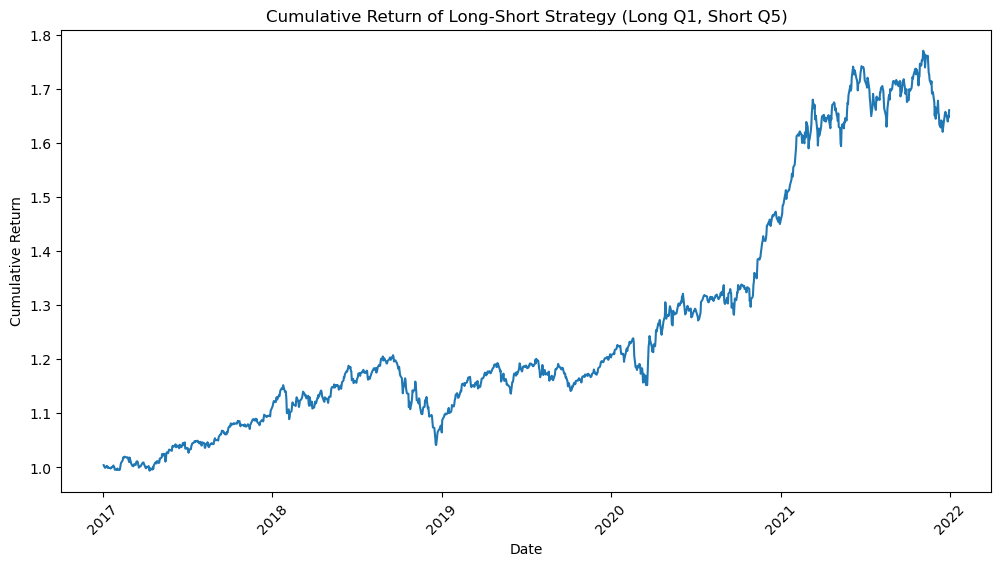

In [ ]:
# Create a column for long-short return: use next-day returns positively for Q1 and negatively for Q5.
merged_df['Long_Short'] = merged_df.apply(lambda row: row['Next_Day_Return'] if row['Quintile']=='Q1'
                                          else (-row['Next_Day_Return'] if row['Quintile']=='Q5' else 0), axis=1)

# Compute daily average long-short return
long_short_returns = merged_df.groupby('Date')['Long_Short'].mean().reset_index()

# Compute cumulative return starting with $1
long_short_returns['Cumulative_Return'] = (1 + long_short_returns['Long_Short']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(long_short_returns['Date'], long_short_returns['Cumulative_Return'])
plt.title('Cumulative Return of Long-Short Strategy (Long Q1, Short Q5)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.xticks(rotation=45)
plt.show()

In [45]:

avg_daily_return = long_short_returns['Long_Short'].mean()
annualized_return = (1 + avg_daily_return)**252 - 1
daily_std = long_short_returns['Long_Short'].std()
sharpe_ratio = (avg_daily_return / daily_std) * np.sqrt(252) if daily_std != 0 else np.nan

print("Average Daily Return (Long-Short):", avg_daily_return)
print("Annualized Return (Long-Short):", annualized_return)
print("Sharpe Ratio (Long-Short):", sharpe_ratio)

Average Daily Return (Long-Short): 0.00042105699745769777
Annualized Return (Long-Short): 0.11191530817461115
Sharpe Ratio (Long-Short): 1.1045641716432004


/var/folders/qj/trm65tt92qn42r8m1wwrh78w0000gn/T/ipykernel_36315/3170578888.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby('Date').apply(assign_deciles).reset_index(drop=True)


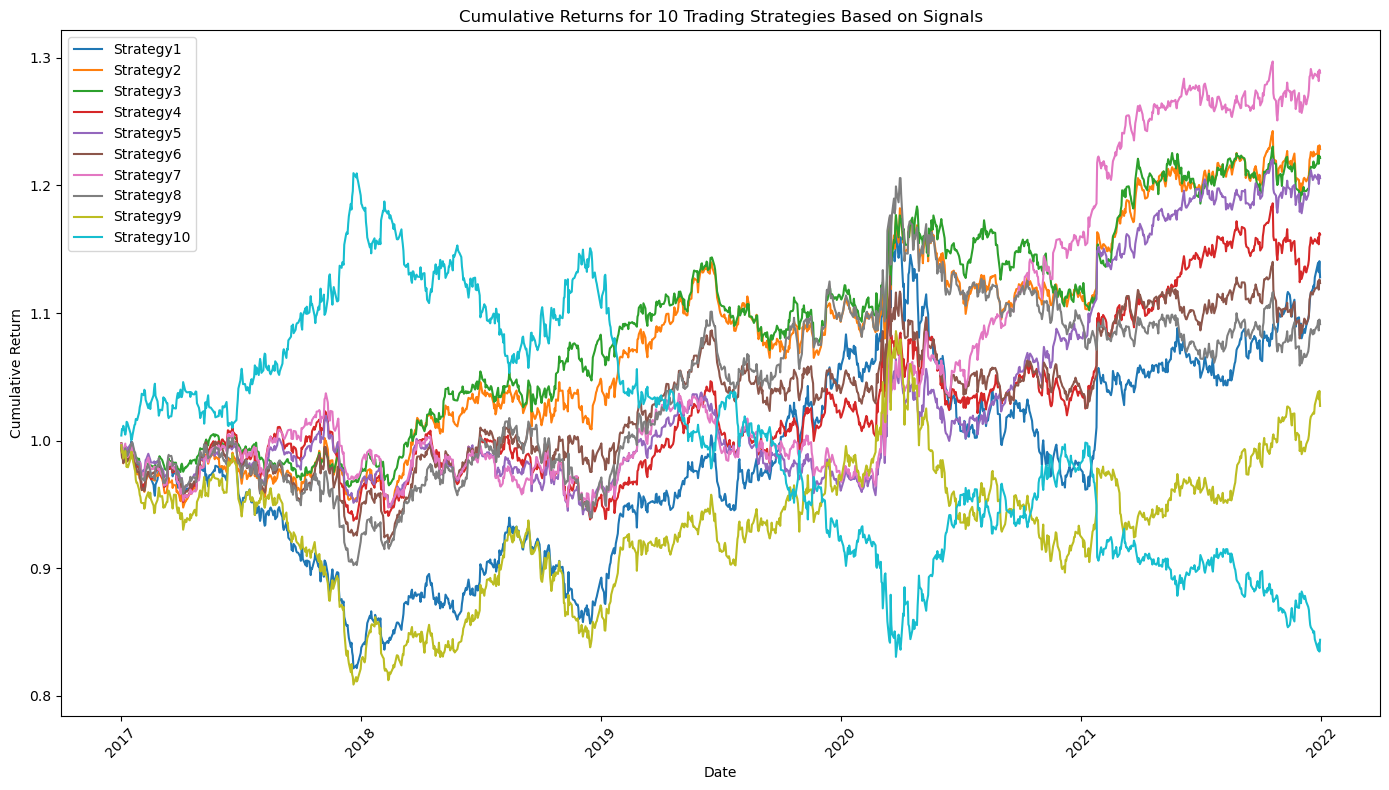

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

merged_df['Date'] = pd.to_datetime(merged_df['Date'])

def assign_deciles(group):
    group = group.copy()
    try:
        # Create deciles using qcut. Note: if there are duplicate edges, qcut will drop some bins.
        # We first perform a temporary qcut to find out the number of bins formed.
        temp_qcut = pd.qcut(group['Signal'], q=10, duplicates='drop')
        n_bins = len(temp_qcut.cat.categories)
        # Generate labels dynamically (1, 2, ..., n_bins). We'll treat higher labels as higher signals.
        labels = list(range(1, n_bins + 1))
        # Reapply qcut with our dynamically generated labels.
        group['Decile'] = pd.qcut(group['Signal'], q=10, labels=labels, duplicates='drop').astype(int)
    except Exception as e:
        # If qcut fails (for instance, if there is only one unique value), assign a default decile.
        group['Decile'] = 1
    return group

# Apply decile assignment on a per-day basis.
merged_df = merged_df.groupby('Date').apply(assign_deciles).reset_index(drop=True)

# ------------------------------------------------------------------------------
# Step 2: Initialize dictionary containers to store daily returns for each strategy.
# We'll develop 10 strategies. For example:
#
# Strategy 1: Long decile 10 and short decile 1.
# Strategy 2: Long decile 10 and short deciles 1-3.
# Strategy 3: Long decile 10 and short deciles 1-5.
# Strategy 4: Long deciles 9-10 and short deciles 1-2.
# Strategy 5: Long deciles 8-10 and short deciles 1-3.
# Strategy 6: Long top 30% (by signal) vs. short bottom 30%.
# Strategy 7: Long stocks above median signal and short stocks below median signal.
# Strategy 8: Long stocks with signal ≥ 80th percentile and short stocks with signal ≤ 20th percentile.
# Strategy 9: Weighted strategy: weighted average return on decile 10 minus that on decile 1.
# Strategy 10: Contrarian: Short decile 10 and long decile 1.
# ------------------------------------------------------------------------------
strategy_returns = {f"Strategy{i}": [] for i in range(1, 11)}
dates_list = []

unique_dates = sorted(merged_df['Date'].unique())

for date in unique_dates:
    daily_data = merged_df[merged_df['Date'] == date].copy()
    

    if daily_data.shape[0] < 10:
        continue  #
   
    max_decile = daily_data['Decile'].max()
    
    # Strategy 1: Long decile 10; Short decile 1.
    s1_long  = daily_data[daily_data['Decile'] == max_decile]['Next_Day_Return'].mean()
    s1_short = daily_data[daily_data['Decile'] == 1]['Next_Day_Return'].mean()
    s1 = s1_long - s1_short
    
    # Strategy 2: Long decile 10; Short deciles 1-3.
    s2_short = daily_data[daily_data['Decile'].isin([1, 2, 3])]['Next_Day_Return'].mean()
    s2 = s1_long - s2_short
    
    # Strategy 3: Long decile 10; Short deciles 1-5.
    s3_short = daily_data[daily_data['Decile'] <= 5]['Next_Day_Return'].mean()
    s3 = s1_long - s3_short
    
    # Strategy 4: Long deciles 9 & 10; Short deciles 1 & 2.
    s4_long  = daily_data[daily_data['Decile'].isin([max_decile-1, max_decile])]['Next_Day_Return'].mean()
    s4_short = daily_data[daily_data['Decile'].isin([1, 2])]['Next_Day_Return'].mean()
    s4 = s4_long - s4_short
    
    # Strategy 5: Long deciles 8-10; Short deciles 1-3.
    # Handle cases where there are less than 10 deciles available.
    long_bins = [d for d in daily_data['Decile'].unique() if d >= max_decile-2]
    s5_long  = daily_data[daily_data['Decile'].isin(long_bins)]['Next_Day_Return'].mean()
    s5_short = daily_data[daily_data['Decile'].isin([1, 2, 3])]['Next_Day_Return'].mean()
    s5 = s5_long - s5_short
    
    # Strategy 6: Long top 30% by signal vs. short bottom 30%.
    p70 = daily_data['Signal'].quantile(0.70)
    p30 = daily_data['Signal'].quantile(0.30)
    s6_long  = daily_data[daily_data['Signal'] >= p70]['Next_Day_Return'].mean()
    s6_short = daily_data[daily_data['Signal'] <= p30]['Next_Day_Return'].mean()
    s6 = s6_long - s6_short
    
    # Strategy 7: Long stocks with Signal above the median, short stocks with Signal below the median.
    med = daily_data['Signal'].median()
    s7_long  = daily_data[daily_data['Signal'] > med]['Next_Day_Return'].mean()
    s7_short = daily_data[daily_data['Signal'] < med]['Next_Day_Return'].mean()
    s7 = s7_long - s7_short
    
    # Strategy 8: Long stocks with Signal at or above the 80th percentile; short stocks at or below the 20th percentile.
    p80 = daily_data['Signal'].quantile(0.80)
    p20 = daily_data['Signal'].quantile(0.20)
    s8_long  = daily_data[daily_data['Signal'] >= p80]['Next_Day_Return'].mean()
    s8_short = daily_data[daily_data['Signal'] <= p20]['Next_Day_Return'].mean()
    s8 = s8_long - s8_short
    
    # Strategy 9: Weighted strategy: weighted average next-day return for decile 10 minus decile 1.
    long_data = daily_data[daily_data['Decile'] == max_decile]
    short_data = daily_data[daily_data['Decile'] == 1]
    # Avoid division by zero by checking the sum of weights (here, we use the Signal as weight)
    if long_data['Signal'].sum() != 0 and short_data['Signal'].sum() != 0:
        weighted_long = (long_data['Next_Day_Return'] * long_data['Signal']).sum() / long_data['Signal'].sum()
        weighted_short = (short_data['Next_Day_Return'] * short_data['Signal']).sum() / short_data['Signal'].sum()
        s9 = weighted_long - weighted_short
    else:
        s9 = np.nan
    
    # Strategy 10: Contrarian strategy: Short decile 10 and long decile 1.
    s10 = s1_short - s1_long  # Reverse of Strategy 1
    
    # Append the results for this day.
    dates_list.append(date)
    strategy_returns["Strategy1"].append(s1)
    strategy_returns["Strategy2"].append(s2)
    strategy_returns["Strategy3"].append(s3)
    strategy_returns["Strategy4"].append(s4)
    strategy_returns["Strategy5"].append(s5)
    strategy_returns["Strategy6"].append(s6)
    strategy_returns["Strategy7"].append(s7)
    strategy_returns["Strategy8"].append(s8)
    strategy_returns["Strategy9"].append(s9)
    strategy_returns["Strategy10"].append(s10)

strategies_daily = pd.DataFrame(strategy_returns, index=pd.to_datetime(dates_list))
strategies_daily.index.name = 'Date'

# Optionally, remove days with missing values.
strategies_daily.dropna(inplace=True)

# ------------------------------------------------------------------------------
# Step 4: Compute cumulative returns for each strategy.
# We'll simulate the growth of an initial investment of $1.
# ------------------------------------------------------------------------------
cumulative_returns = (1 + strategies_daily).cumprod()

# ------------------------------------------------------------------------------
# Step 5: Plot the cumulative returns for all 10 strategies.
# ------------------------------------------------------------------------------
plt.figure(figsize=(14,8))
for strat in strategies_daily.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[strat], label=strat)

plt.title("Cumulative Returns for 10 Trading Strategies Based on Signals")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Write Up

The majority of the work that I did on this project was to adjust the outputs of chatGPT's o3-mini-high model. After feeding it the information from the deliverable 1 pdf, it produced the majority of the output that you see here. After that it was a matter of simply processing errors and prompting in order to solve the issues that arised. As is commented, the dates are adjusted to be localized in UTC before being converted into eastern standard. The 4pm cutoff makes sure that all of the data fits into it's "effective date".